In [1]:
import numpy as np
import astropy.units as u
from gammapy.modeling import Parameter

In [2]:
class LinkedParameter(Parameter):
    def __init__(self, par1, par2, operator=None):
        self.par1 = par1
        self.par2 = par2
        self.check_units()
        self.operator=operator

        self._value1 = par1.value
        self._value2 = par2.value
        value = self.evaluate()
        
        super().__init__(
            self.par1.name, 
            value, 
            self.par1.unit,
            frozen=True
        )

    def check_units(self):
        pass

    def evaluate(self):
        if self.operator:
            return self.operator(self._value1, self._value2)
        else:
            return self._value2
            
    def update(self):
        if self.par2.value != self._value2:
            self._value2 = self.par2.value
        if self.operator and self.par1.value != self._value1:
            self._value1 = self.par1.value
        self.value = self.evaluate()
        
    @property
    def value(self):
        """Factor (float)."""
        self.update()
        return self.evaluate()
        
    @value.setter
    def value(self, val):
        self.factor = float(val) / self._scale

In [3]:
def __set__(self, instance, value):
    if isinstance(value, Parameter) and self.unit.is_equivalent(value.unit):
        if self.name == value.name:
            instance.__dict__[self.name] = value
        else:
            instance.__dict__[self.name] = LinkedParameter(self, value)            
    else:
        par = instance.__dict__[self.name]
        raise TypeError(f"Cannot assign {value!r} to parameter {par!r}")
Parameter.__set__ = __set__

In [4]:
import collections.abc
def _arithmetics(self, other, operator=None):
    """Perform arithmetic on parameters"""
    if not isinstance(other, Parameter):
        if isinstance(other, collections.abc.Sequence):
            raise TypeError(f"unsupported operand type(s) for {str(operator)}: {type(self)} and {type(other)}")
        else:
            other = u.Quantity(other)
            other = ConstantParameter(other.value, other.unit)
            
    return LinkedParameter(self, other, operator)

def __add__(self, other):
    return self._arithmetics(other, np.add)

def __sub__(self, other):
    return self._arithmetics(other, np.subtract)

def __mul__(self, other):
    return self._arithmetics(other, np.multiply)

def __truediv__(self, other):
    return self._arithmetics(other, np.true_divide)

Parameter._arithmetics = _arithmetics
Parameter.__add__ = __add__
Parameter.__sub__ = __sub__
Parameter.__mul__ = __mul__
Parameter.__truediv__ = __truediv__

In [5]:
class ConstantParameter(Parameter):
    def __init__(self, value, unit, name=None):
        if not name:
            name = str(value) + str(unit)
            
        super().__init__(name, value, unit, frozen=True)
print(ConstantParameter(3, ""))
print(ConstantParameter(3, "TeV"))

ConstantParameter(name='3', value=3.0, factor=3.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=True, id=0x7efee5ebd6a0)
ConstantParameter(name='3TeV', value=3.0, factor=3.0, scale=1.0, unit=Unit("TeV"), min=nan, max=nan, frozen=True, id=0x7efee5ebddc0)


## Check parameters linking with identity operation (`par1=par2`)

In [6]:
# THIS SHOULD FAIL (UNITS DO NOT MATCH)
from gammapy.modeling.models import BrokenPowerLawSpectralModel
model = BrokenPowerLawSpectralModel()
model.index1 = model.amplitude
model.index1

TypeError: Cannot assign Parameter(name='amplitude', value=1e-12, factor=1e-12, scale=1.0, unit=Unit("1 / (cm2 s TeV)"), min=nan, max=nan, frozen=False, id=0x7eff284d9130) to parameter Parameter(name='index1', value=2.0, factor=2.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7efedca4ce50)

In [7]:
# THIS SHOULD NOT FAIL 
from gammapy.modeling.models import BrokenPowerLawSpectralModel, PowerLawSpectralModel
model1 = BrokenPowerLawSpectralModel(index1=2)
model2 = PowerLawSpectralModel(index=3)
model1.index1 = model2.index
model1.index1

LinkedParameter(name='index1', value=3.0, factor=3.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=True, id=0x7eff28376d00)

Check that the parameters are correctly linked

In [8]:
model2.index.value = 18
model1.index1

LinkedParameter(name='index1', value=18.0, factor=18.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=True, id=0x7eff28376d00)

## Check parameters linking with arithmetic operations

In [9]:
from gammapy.modeling.models import BrokenPowerLawSpectralModel
model = BrokenPowerLawSpectralModel(index1=1, index2=4)
model.index2 = model.index1 + 1
model.index2

LinkedParameter(name='index2', value=2.0, factor=2.0, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=True, id=0x7efeea642220)

## Test behavior during fitting

In [10]:
from gammapy.datasets import MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, FoVBackgroundModel

In [11]:
dataset = MapDataset.read("/home/lucagiunti/gammapy-datasets/cta-1dc-gc/cta-1dc-gc.fits.gz")
dataset = dataset.to_spectrum_dataset(on_region=None)

model = BrokenPowerLawSpectralModel(index1=1, index2=3)
model.amplitude.value = 1e-10
skymodel = SkyModel(spectral_model=model, name="sim")

bkg = FoVBackgroundModel(dataset_name=dataset.name)
dataset.models = [bkg, skymodel]
dataset.fake()

/home/lucagiunti/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/astropy/units/quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
model = BrokenPowerLawSpectralModel()
model.index2 = model.index1 + 2
skymodel_fit = SkyModel(spectral_model=model, name="fit")
dataset.models = [bkg, skymodel_fit]

In [13]:
fit = Fit()
result = fit.run(dataset)

In [14]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,norm,9.9894e-01,,1.247e-02,nan,nan,False,True,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,index1,1.0224e+00,,2.679e-01,nan,nan,False,False,
spectral,index2,3.0224e+00,,0.000e+00,nan,nan,True,False,
spectral,amplitude,9.5081e-11,cm-2 s-1 TeV-1,4.204e-11,nan,nan,False,True,
spectral,ebreak,1.0420e+00,TeV,2.048e-01,nan,nan,False,False,


(<AxesSubplot: xlabel='Energy [TeV]', ylabel='$\\mathrm{}$'>,
 <AxesSubplot: xlabel='Energy [TeV]', ylabel='Residuals\ndata - model'>)

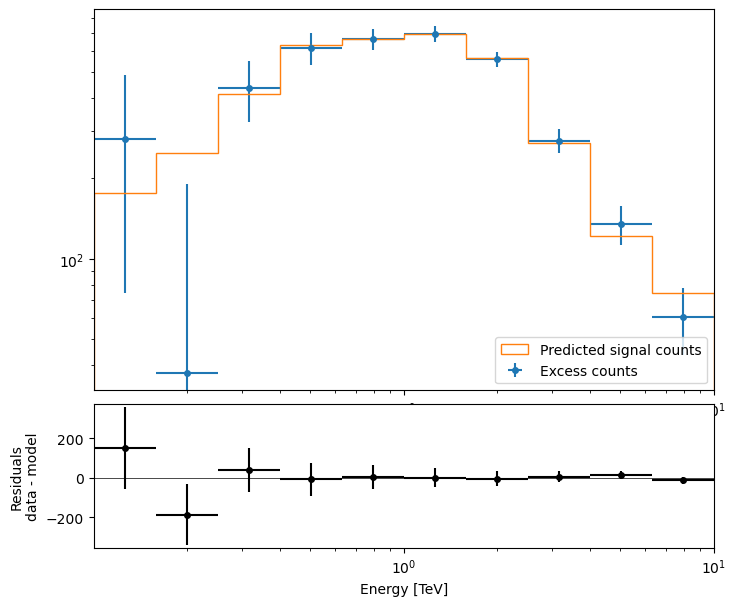

In [15]:
dataset.plot_fit()